# Classification

In this example we will do some simple cell classification based on multiband imagery and a
target/label raster. Classification is the process of learning a mapping between points and labels, and then applying that mapping to other points whose labels are unknown.

## Setup

First some setup. There are imports to make and the spark instance must be initialized.

In [1]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
from pyrasterframes.types import NoDataFilter
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pathlib import Path

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()

## Loading Data

The first step is to load multiple bands of imagery and construct a single RasterFrame from them.
To do this we:

1. Identify the GeoTIFF filename. 
2. Read the TIFF raster
3. Create the names of our columns
4. Define a function for reading in a RasterFrame based on a band number
5. Use the RasterFrames `spatialJoin` function to create a new RasterFrame with a column for each band

In [2]:
# Utility for reading imagery from our test data set
resource_dir = Path('./samples').resolve()
# Utility for reading imagery from our test data set
filenamePattern = "L8-B{}-Elkton-VA.tiff"
bandNumbers = range(1, 8)
bandColNames = ['band_{}'.format(n) for n in bandNumbers]

def readTiff(band):
    return spark.read.geotiff(resource_dir.joinpath(filenamePattern.format(band)).as_uri())

from functools import reduce
joinedRF = reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2.drop('bounds').drop('metadata')),
                  [readTiff(b).withColumnRenamed('tile', 'band_{}'.format(b)) for b in bandNumbers])

We should see a single `spatial_key` column along with 7 columns of tiles.

In [3]:
joinedRF.printSchema()

root
 |-- spatial_key: struct (nullable = false)
 |    |-- col: integer (nullable = false)
 |    |-- row: integer (nullable = false)
 |-- bounds: polygon (nullable = true)
 |-- metadata: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = false)
 |-- band_1: rf_tile (nullable = false)
 |-- band_2: rf_tile (nullable = false)
 |-- band_3: rf_tile (nullable = false)
 |-- band_4: rf_tile (nullable = false)
 |-- band_5: rf_tile (nullable = false)
 |-- band_6: rf_tile (nullable = false)
 |-- band_7: rf_tile (nullable = false)



Similarly pull we pull in the target label data.

In [4]:
targetCol = "target"

target = spark.read.geotiff(resource_dir.joinpath("L8-Labels-Elkton-VA.tiff") \
                            .as_uri()).withColumnRenamed('tile', targetCol)

Take a peek at what kind of label data we have to work with. `aggStats` returns the number of data cells, NODATA cells, min, max, mean, and variance respectively, aggregated down an entire column (which in this case is only one tile).

In [5]:
target.select(aggStats("target")).show(1, False)

+----------------------------------------------------------+
|aggStats(target)                                          |
+----------------------------------------------------------+
|[1626,29808,0.0,2.0,0.8031980319803198,0.2798421711154381]|
+----------------------------------------------------------+



Join the target label RasterFrame with the band tiles to create our analytics base table

In [6]:
abt = joinedRF.spatialJoin(target).drop('bounds', 'metadata').asRF()

Add the target column to the list of columns for preparation for the machine learning pipeline.

In [7]:
def append(lst, elem):
    return tuple(lst + [elem])

append(bandColNames, targetCol)

('band_1',
 'band_2',
 'band_3',
 'band_4',
 'band_5',
 'band_6',
 'band_7',
 'target')

## ML Pipeline

The data preparation modeling pipeline is next. SparkML requires that each observation be in 
its own row, and those observations be packed into a single vector. The first step is 
to "explode" the tiles into a single row per cell/pixel. Then we filter out any rows that
have `NODATA` values (which will cause an error during training). Finally we use the
PySparkML `VectorAssembler` to create the vector. 

In [8]:
exploder = TileExploder()

ndFilter = NoDataFilter()
ndFilter.setInputCols(append(bandColNames, targetCol))

assembler = VectorAssembler(inputCols=bandColNames, outputCol="features")

We are going to use a decision tree for classification. You can swap out one of the other multi-class
classification algorithms if you like. With the algorithm selected, we can assemble our modeling pipeline.

In [9]:
classifier = DecisionTreeClassifier(labelCol="target", featuresCol=assembler.getOutputCol())

pipeline = Pipeline(stages=[exploder, ndFilter, assembler, classifier])

Push the "go" button to fit the model (train it on the target data) and then transform the data using the model (apply the mapping the model has learned to unknown data points).

In [10]:
model = pipeline.fit(abt)

fitted = model.transform(abt)

We can see that when we sent the RasterFrame through the pipeline it emerged with a few new columns ("features", "rawPrediction", "probability", and "prediction".

In [11]:
fitted.printSchema()

root
 |-- spatial_key: struct (nullable = false)
 |    |-- col: integer (nullable = false)
 |    |-- row: integer (nullable = false)
 |-- column_index: integer (nullable = false)
 |-- row_index: integer (nullable = false)
 |-- band_1: double (nullable = false)
 |-- band_2: double (nullable = false)
 |-- band_3: double (nullable = false)
 |-- band_4: double (nullable = false)
 |-- band_5: double (nullable = false)
 |-- band_6: double (nullable = false)
 |-- band_7: double (nullable = false)
 |-- target: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



## Model Evaluation

To view the model's performance we create an evaluator and compare the result and the ground truth based on accuracy.

In [12]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(fitted)

In [13]:
accuracy

0.9993849938499385

Finally, we score the original data set (including the cells without target values) and 
add up class membership results.

In [14]:
scored = model.transform(joinedRF)

scored.groupby("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 9682|
|       1.0|13459|
|       2.0| 8293|
+----------+-----+



## Visualizing Results

The predictions are in a DataFrame with each row representing a separate pixel. 
To assemble a raster to visualize the class assignments, we have to go through a
multi-stage process to get the data back in tile form, and from there to combined
raster form.

First, we get the DataFrame back into RasterFrame form:

In [15]:
tlm = joinedRF.tileLayerMetadata()
layout = tlm['layoutDefinition']['tileLayout']

retiled = scored.groupBy('spatial_key').agg(
    assembleTile('column_index', 'row_index', 'prediction',
        layout['tileCols'], layout['tileRows'], 'int8')
)

rf = retiled.asRF("spatial_key", tlm)

Before we were forced to treat "prediction" as an iterable, but now we can call columnar functions on it!

In [16]:
rf.select(tileStats("prediction")).show(truncate=False)

+--------------------------------------------------------+
|tileStats(prediction)                                   |
+--------------------------------------------------------+
|[31434,-1,0.0,2.0,0.9558121778965452,0.5698804833969046]|
+--------------------------------------------------------+



We are going to use matplotlib to visualize the results of our clustering, which requires first getting the data into a two dimensional array, which we do using numpy.

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

raster = np.asarray(list(rf.toIntRaster("prediction", 186, 169)))
pixels = np.reshape(raster, (169, 186))

We can now plot the labeled image, the original RGB image, and the target labels like any other picture.

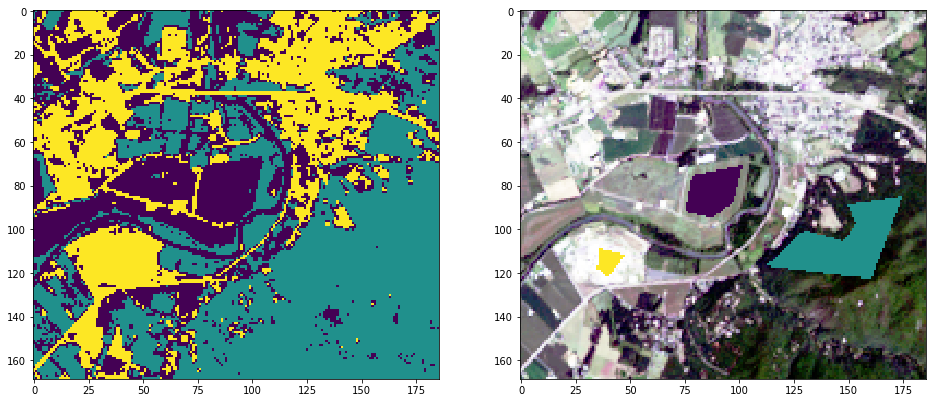

In [18]:
fig = plt.figure(figsize=(16,16))


fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(pixels)
imgplot.set_cmap('viridis')
fig.add_subplot(1, 2, 2)
pixels2 = mpl.pyplot.imread("pics/L8-RGB-VA.png")
imgplot = plt.imshow(pixels2)
fig.add_subplot(1, 2, 2)
pixels3 = mpl.pyplot.imread("pics/target-labels.png")
imgplot = plt.imshow(pixels3)

On the left we can see the assignments made by classifier. On the right we can see the ground truth training set laid on top of the original RGB image. It appears that the labels seperate dense vegetation, farmland, and an urban area, which is reflected fairly accurately in the model's assignments.